In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt

In [2]:
trolley = pd.read_csv('Data/trolley.csv',sep=';')
trolley['story'].value_counts()

bur    1324
box    1324
spe     993
swi     993
aqu     662
rub     662
boa     662
car     662
che     662
sha     662
pon     662
shi     662
Name: story, dtype: int64

In [16]:
trolley.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


For any given estimand there may be multiple estimators possible, and some may be better. 

In [11]:
story_r = trolley.groupby('story').response.mean()

(1.0, 7.0)

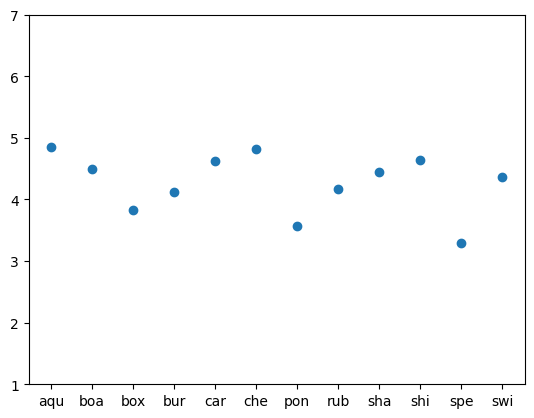

In [27]:
plt.scatter(y=story_r.values,x=story_r.index)

plt.ylim((1,7))

R ~ OrderedLogit(phi,alpha)

phi = Bs[i]

This model has anterograde amnesia. Does not remember how people respond from one story to another. It's a brand new B for each story! 

This is inneficient. The model starts out witha  naive prior, it should update the prior once it learns about similar things (i.e. stories)

## Models With Memory

**Multilevel models** are models within models

1) Model observed groups/individuals

2) Model of population of groups/individuals

The population model creates a kind of memory.

## Two Perspectives

1) Models with memory learn faster, better

2) Models with memory resist overfitting

## Starbucks Example

Model how long peopel have to wait when they go to a starbucks

It should learn about starbucks visits as it travels from cafe to cafe. 

The order you visit cannot matter. The posterior distributions have to be the same. 

The robot learns how different each cafe is. 

## Regularization

Another reason for multilevel models is that they adaptively regularize

Complete pooling: Treat all clusters as identical => underfitting

No pooling: Treat all clusters as unrelated => overfitting (What we've been doing!). Can radically overfit

Partial Pooling: Adaptive compromise

## Reedfrogs in peril

data(reedfrogs)

48 groups ("tanks") of tadpoles

Treatments: density,size,predation

Outcome: survival

Variables:

- (T) tank
- (D) density
- (G) size
- (P) predators

In [29]:
frogs = pd.read_csv('Data/reedfrogs.csv',sep=';')
frogs.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


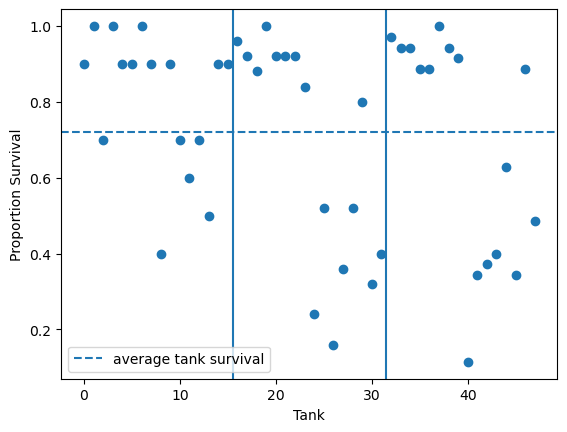

In [41]:
plt.scatter(y=frogs['propsurv'],x=frogs.index)
plt.axhline(y=frogs['propsurv'].mean(),linestyle='--',label='average tank survival')
plt.axvline(x=15.5)
plt.axvline(x=31.5)
plt.ylabel('Proportion Survival')
plt.xlabel('Tank')
plt.legend()

S ~ Binomial(D,p)

logit(pi) = aT[i]

aj ~ Normal(abar,sigma)

abar ~ Normal(0,1.5) A parameter for the average tank

sigma ~ Exponential(1)

Can choose through cross-validation score, how well it fits to out-of sample score. 

In [57]:
predidx,pred = frogs['pred'].factorize()
sizeidx,size = frogs['size'].factorize()
sizeidx

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1], dtype=int64)

In [54]:
coords= {'Size':size,'Pred':pred}

In [100]:
frogs['density'].values

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35],
      dtype=int64)

In [118]:
with pm.Model() as frog_m:
    D = pm.MutableData('D',frogs['density'].values)
    P = pm.MutableData('P',predidx)
    Si = pm.MutableData('S',sizeidx)
    T = pm.MutableData('T',frogs.index.values)
    Su = pm.MutableData('Su',frogs['surv'].values)
    
    sigma = pm.Exponential('sigma',1.0)
    a_bar = pm.Normal('a_bar',0.0,1.5)
    a     = pm.Normal('a',a_bar,sigma,shape=T.shape[0])

    p      = a[T]
    Survive     = pm.Binomial('Survive',n=D,logit_p=p,observed=Su)
    
    frog_trace = pm.sample()
    pm.compute_log_likelihood(frog_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_bar, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [119]:
az.summary(frog_trace,var_names=['a_bar','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.341,0.260,0.867,1.835,0.004,0.003,4862.0,3120.0,1.0
sigma,1.609,0.207,1.234,1.993,0.004,0.003,2869.0,3403.0,1.0


In [120]:
with pm.Model() as frog2_m:
    D = pm.MutableData('D',frogs['density'].values)
    P = pm.MutableData('P',predidx)
    Si = pm.MutableData('S',sizeidx)
    T = pm.MutableData('T',frogs.index.values)
    Su = pm.MutableData('Su',frogs['surv'].values)
    
    a_bar = pm.Normal('a_bar',0,1.5)
    a     = pm.Normal('a',a_bar,1,shape=T.shape[0])
    Survive = pm.Binomial('Survive',n=D,logit_p=a[T],observed=Su)
    
    frog2_trace = pm.sample()
    pm.compute_log_likelihood(frog2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [121]:
az.summary(frog2_trace,var_names=['a_bar'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.209,0.171,0.906,1.559,0.002,0.002,4952.0,3274.0,1.0


In [126]:
az.compare({'frog':frog_trace,
            'frog2':frog2_trace},
          ic = 'waic')

# Notice model with more parameters has lower overfitting (lower p_waic)

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
frog,0,-99.766650,20.655357,0.000000,1.0,3.555330,0.000000,True,log
frog2,1,-109.027638,26.012144,9.260988,0.0,3.926226,2.265589,True,log


In [127]:
# Stratifying mean by predators now
with pm.Model() as frogp_m:
    
    D = pm.MutableData('D',frogs['density'].values)
    P = pm.MutableData('P',predidx)
    Si = pm.MutableData('S',sizeidx)
    T = pm.MutableData('T',frogs.index.values)
    Su = pm.MutableData('Su',frogs['surv'].values)
    
    sigma = pm.Exponential('sigma',1.0)
    a_bar = pm.Normal('a_bar',0.0,1.5)
    a     = pm.Normal('a',a_bar,sigma,shape=T.shape[0])
    bP    = pm.Normal('bP',0,0.5)
    p      = a[T] + bP*P
    Survive     = pm.Binomial('Survive',n=D,logit_p=p,observed=Su)
    
    frogp_trace = pm.sample()
    pm.compute_log_likelihood(frogp_trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_bar, a, bP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Text(0.5, 0, 'bP (effect of predators)')

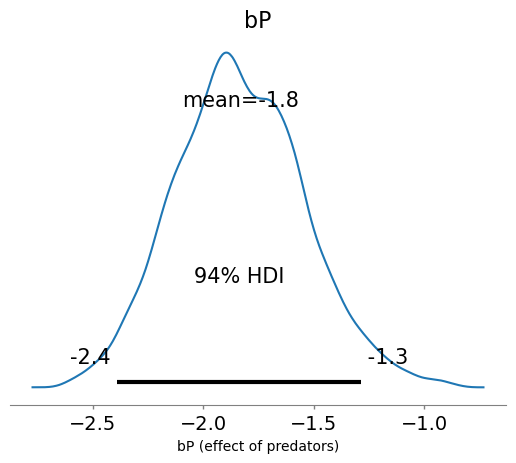

In [130]:
az.plot_posterior(frogp_trace,var_names=['bP'])
plt.xlabel('bP (effect of predators)')

In [131]:
with frog_m:
    frog_preds = pm.sample_posterior_predictive(frog_trace)

Sampling: [Survive]


In [132]:
with frogp_m:
    frogp_preds = pm.sample_posterior_predictive(frogp_trace)

Sampling: [Survive]


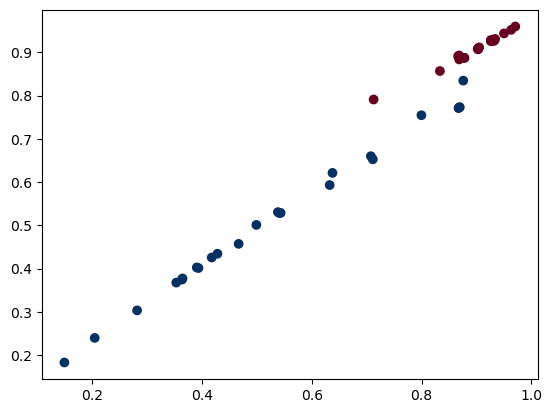

In [144]:
frogpred_m = frog_preds.posterior_predictive.Survive.mean(dim=['chain','draw'])
frogppred_m = frogp_preds.posterior_predictive.Survive.mean(dim=['chain','draw'])

plt.scatter(frogpred_m/frogs['density'],frogppred_m/frogs['density'],c=predidx,cmap='RdBu')

<AxesSubplot: >

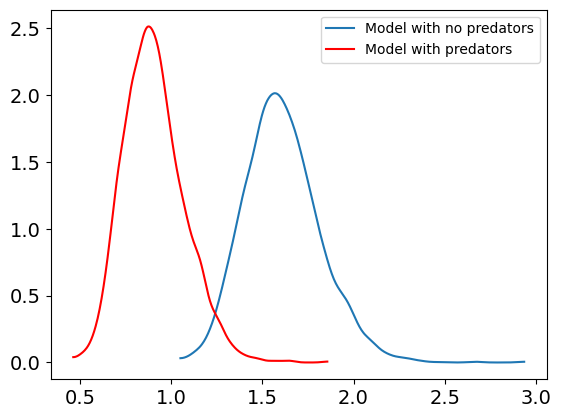

In [156]:
az.plot_kde(frog_trace.posterior['sigma'].values,label='Model with no predators')
az.plot_kde(frogp_trace.posterior['sigma'].values,plot_kwargs={'c':'Red'},label='Model with predators')

Models make very similar predictions, but sigma is doing a lot less heavy lifting in the model that stratifies by predators

## Multilevel Tadpoles

Model of unobserved population helps learn about observed units

Use data efficiently, reduce overfitting

Varying effects: Unit-specific partially pooled estimates (alpha, random effects)

What about D and G? 

In [157]:
with pm.Model() as frogpdg_m:
    
    D = pm.MutableData('D',frogs['density'].values)
    P = pm.MutableData('P',predidx)
    G = pm.MutableData('G',sizeidx)
    T = pm.MutableData('T',frogs.index.values)
    Su = pm.MutableData('Su',frogs['surv'].values)
    
    sigma = pm.Exponential('sigma',1.0)
    a_bar = pm.Normal('a_bar',0.0,1.5)
    a     = pm.Normal('a',a_bar,sigma,shape=T.shape[0])
    bP    = pm.Normal('bP',0,0.5)
    bD    = pm.Normal('bD',0,0.5)
    bG    = pm.Normal('bG',0,0.5)
    p      = a[T] + bP*P + bD*D + bG*G
    Survive     = pm.Binomial('Survive',n=D,logit_p=p,observed=Su)
    
    frogpdg_trace = pm.sample()
    pm.compute_log_likelihood(frogpdg_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_bar, a, bP, bD, bG]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [158]:
az.summary(frogpdg_trace,var_names=['a_bar','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,2.446,0.456,1.544,3.214,0.033,0.023,194.0,399.0,1.01
sigma,0.844,0.171,0.534,1.154,0.006,0.004,771.0,1834.0,1.00


<AxesSubplot: >

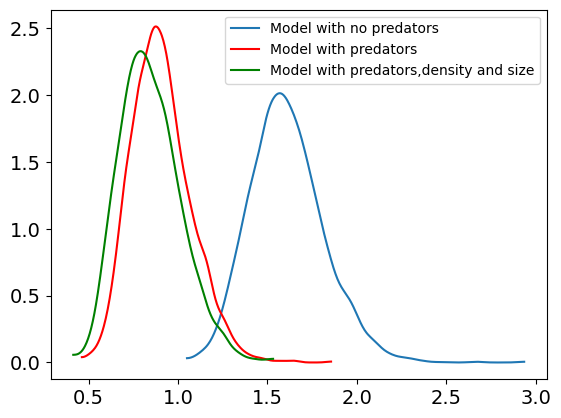

In [159]:
az.plot_kde(frog_trace.posterior['sigma'].values,label='Model with no predators')
az.plot_kde(frogp_trace.posterior['sigma'].values,plot_kwargs={'c':'Red'},label='Model with predators')
az.plot_kde(frogpdg_trace.posterior['sigma'].values,plot_kwargs={'c':'Green'},label='Model with predators,density and size')

## Varying  Effect Superstitions

Varying effect models are plagued by superstition

1) Units must be sampled at random: Not true, partial pooling just speeds up learning, doesn't matter how samples got into the dataset

2) Number of units must be large: Not true, no sample size constraint

3) Assumes Gaussian variation: Not true, distributions in the models are not claims about frequencies in the real world, they are prior expectations before we see the data. A gaussian prior is not a claim that the data look normal, its a prior expectation for the residuals net the error variants. The posterior distribution does not have to be gaussian (gaussians can learn non-gaussians). you can use other priors if you like

## Practical Difficulties

Varying effectss are a good default, but...

1) How to use more than one cluster type at the same time? For example stories and participants

2) How to sample efficienctly?

3) What about slopes? Confounds?

## Random Confounds

When unobserved group featuress influence individually-varying causes

Dizzying terminology: group-level confounding, endogeneity, correlated errors, econometrics

Group-level variables have direct and indirect influences. 

(tank traits, unobserved) G -> S (survival) <- Z (group trait) 

individual traits are influenced by tank traits and influence survival 

These kinds of models are used in classroom studies, political science. 

Estimand: Influence of X on Y

Estimator?

1) Fixed effects model

2) Multilevel model

3) Mundlak Machines: multilevel machine that takes into account confounding

In [250]:
N_groups = 30
N_id = 200
a0 = -2
bZY = -0.5

g  = np.random.choice(a=N_groups,size=N_id,replace=True) #Sample into groups
Ug = np.random.normal(1.5,size=groups) # group confounds
X  = np.random.normal(Ug[g],size=N_id) # Individual varying trait
Z  = np.random.normal(size=N_groups) # group varying trait (observed)
Y = np.random.binomial(1,p= expit(a0 + 1*X + 1*Ug[g] +bZY*Z[g]),size=N_id)


## Fixed effects model

Estimate a different average rate for each group, without pooling

Inefficient, but soaks up group-level (fixed) confounding (G)

Problem: Cannot identify any group-level effects (Z)

In [251]:
with pm.Model() as fixed_m:
    bXY = pm.Normal('bXY',0,1)
    bZY = pm.Normal('bZY',0,1)
    a  = pm.Normal('a',0,10,shape = g.shape[0])
    
    p  = a[g] + bXY*X + bZY*Z[g]
    
    y  = pm.Bernoulli('y',logit_p=p,observed=Y)
    
    fixed_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bXY, bZY, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [252]:
fixed_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<AxesSubplot: title={'center': 'bXY'}>,
       <AxesSubplot: title={'center': 'bZY'}>,
       <AxesSubplot: title={'center': 'a'}>], dtype=object)

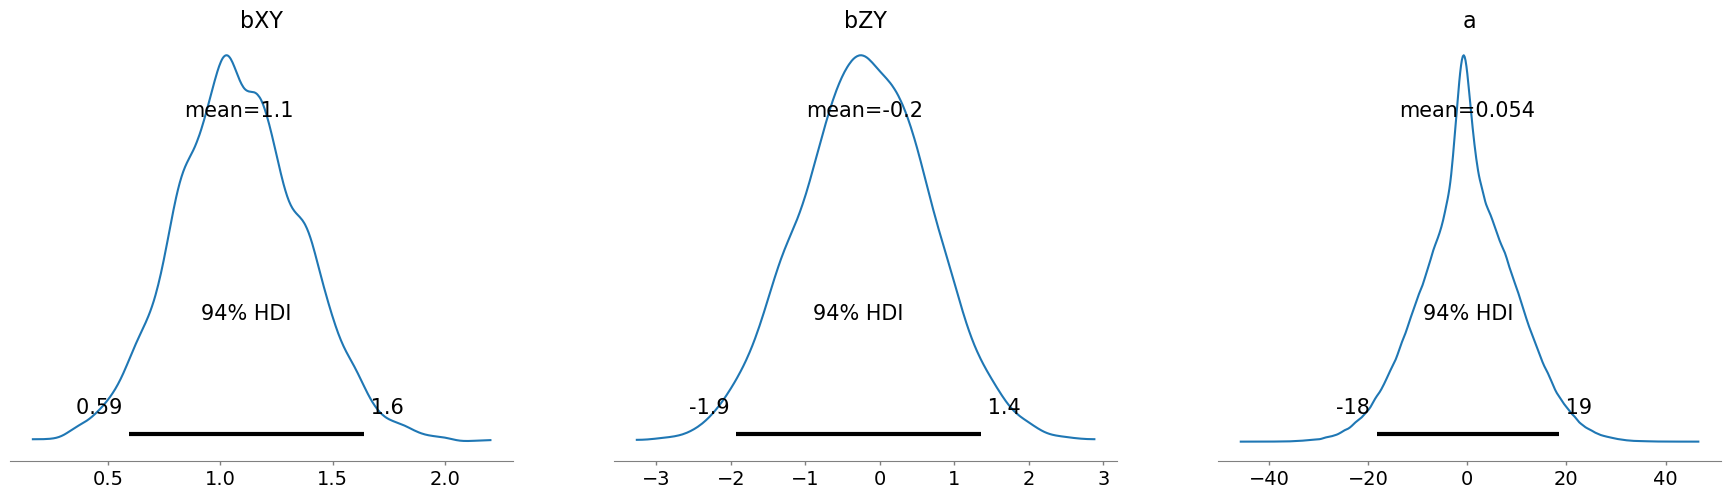

In [253]:
az.plot_posterior(fixed_trace, combine_dims={'bZY_dim_0','a_dim_0'})

#High density value is concentrated over the true value for bXY 
# Very spread out for bZY  and a 
# Can't separate the intercept from the gradient

## Multilevel model

Estimate a different average rate for each group, partial pooling

Better estimates for G, worse estimate for X

Bonus: Can identify Z

Fixed effects are better at removing group level confounding, multi is better at estimation and therefore prediction.

Fixed can be better for inference (do X), if you don't care about prediction

In [254]:
with pm.Model() as multi_m:
    bXY = pm.Normal('bXY',0,1)
    bZY = pm.Normal('bZY',0,1)
    a_bar = pm.Normal('a_bar',0,1)
    tau = pm.Exponential('tau',1)

    z  = pm.Normal('z',0,1,shape=g.shape[0])
    a  = a_bar + z*tau
    p  = a[g] + bXY*X + bZY*Z[g]
    
    y  = pm.Bernoulli('y',logit_p=p,observed=Y)
    
    multi_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bXY, bZY, a_bar, tau, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


<AxesSubplot: >

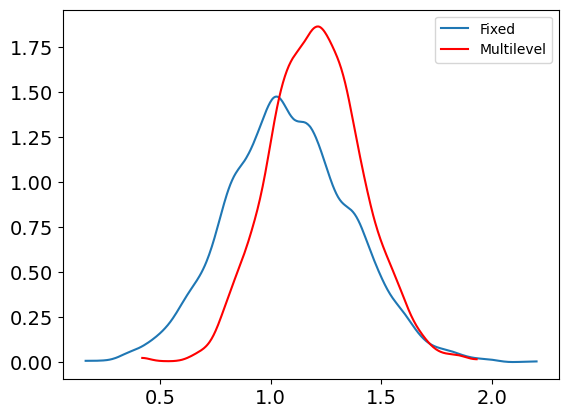

In [255]:
az.plot_kde(fixed_trace.posterior['bXY'].values,label='Fixed')
az.plot_kde(multi_trace.posterior['bXY'].values,plot_kwargs={'c':'Red'},label='Multilevel')
#Not entirely certain if correct

## Mundlak machine

Estimate a different average rate for each group, partial pooling

Include group average X

Better X, but improper respect for uncertainty in X-bar

In [256]:
with pm.Model() as mundlak_m:
    xbar = np.array([np.mean(X[g==j]) for j in range(N_groups)])
    bXY = pm.Normal('bXY',0,1)
    bZY = pm.Normal('bZY',0,1)
    buy = pm.Normal('buy',0,1)
    a_bar = pm.Normal('a_bar',0,1)
    tau = pm.Exponential('tau',1)

    z  = pm.Normal('z',0,shape=g.shape[0])
    a  = a_bar + z*tau
    p  = a[g] + bXY*X + bZY*Z[g] + buy*xbar[g]
    
    y  = pm.Bernoulli('y',logit_p=p,observed=Y)
    
    mundlak_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bXY, bZY, buy, a_bar, tau, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<AxesSubplot: >

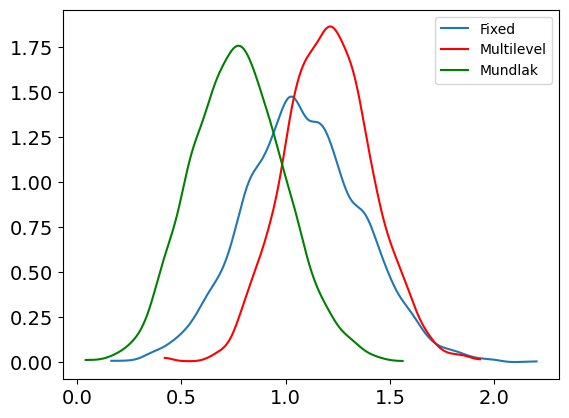

In [257]:
az.plot_kde(fixed_trace.posterior['bXY'].values,label='Fixed')
az.plot_kde(multi_trace.posterior['bXY'].values,plot_kwargs={'c':'Red'},label='Multilevel')
az.plot_kde(mundlak_trace.posterior['bXY'].values,plot_kwargs={'c':'Green'},label='Mundlak')

<AxesSubplot: >

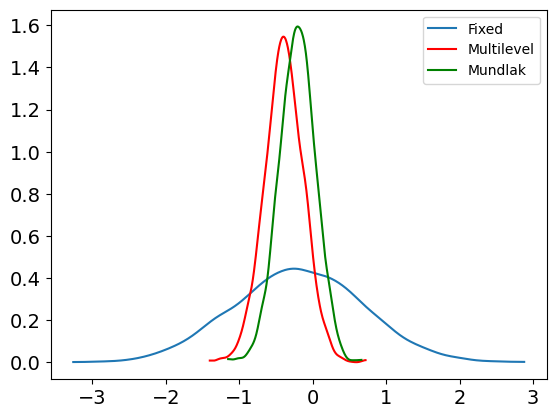

In [258]:
az.plot_kde(fixed_trace.posterior['bZY'].values,label='Fixed')
az.plot_kde(multi_trace.posterior['bZY'].values,plot_kwargs={'c':'Red'},label='Multilevel')
az.plot_kde(mundlak_trace.posterior['bZY'].values,plot_kwargs={'c':'Green'},label='Mundlak')

## Full Luxury Bayes

aka Latent Mundlak Machine

Just express the generative model

Trat G as unknown and us Xi to estimate

Two simultaneous regressions

1) Estimate Xi|do(G)
2) Estimate Yi|do(Xi)

Respects uncertainty in G

In [259]:
# Latent Mundlak Machine

with pm.Model() as latent_m:
    #Priors
    sigma = pm.Exponential('sigma',1)
    tau   = pm.Exponential('tau',1)
    abar  = pm.Normal('abar',0,1)
    bux   = pm.Exponential('bux',1)
    aX    = pm.Normal('aX',0,1)
    bxy   = pm.Normal('bxy',0,1)
    buy   = pm.Normal('buy',0,1)
    bzy   = pm.Normal('bzy',0,1)
    z     = pm.Normal('z',0,1,shape=g.shape[0])
    
    #X model
    u  = pm.Normal('u',0,1,shape=g.shape[0])
    mu = aX + bux*u[g]
    
    Xobs = pm.Normal('Xobs',mu,sigma, observed = X)
    
    #Y model
    a = abar + z*tau
    p = a[g] + bxy*X + bzy*Z[g] + buy*u[g]
    
    Yobs = pm.Bernoulli('Yobs',logit_p=p,observed = Y)
    
    latent_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, abar, bux, aX, bxy, buy, bzy, z, u]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [260]:
latent_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

<AxesSubplot: >

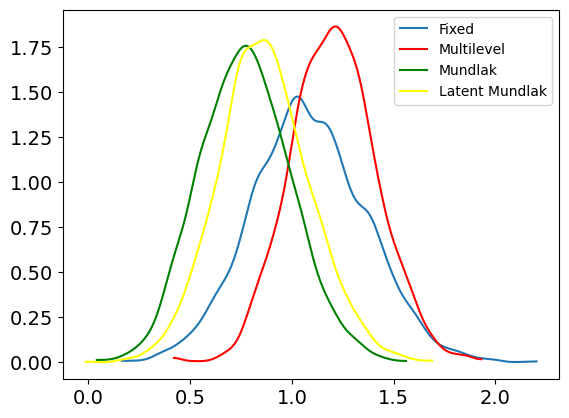

In [261]:
az.plot_kde(fixed_trace.posterior['bXY'].values,label='Fixed')
az.plot_kde(multi_trace.posterior['bXY'].values,plot_kwargs={'c':'Red'},label='Multilevel')
az.plot_kde(mundlak_trace.posterior['bXY'].values,plot_kwargs={'c':'Green'},label='Mundlak')
az.plot_kde(latent_trace.posterior['bxy'].values,plot_kwargs={'c':'Yellow'},label='Latent Mundlak')

<AxesSubplot: >

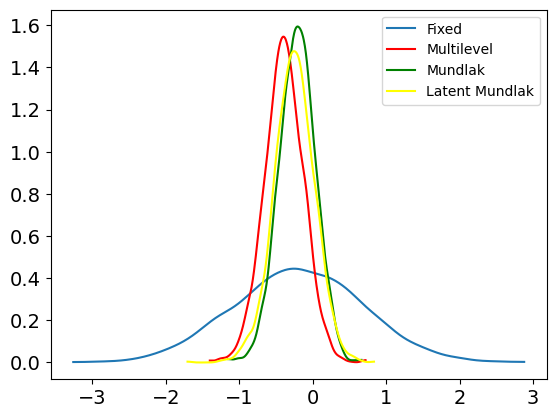

In [262]:
az.plot_kde(fixed_trace.posterior['bZY'].values,label='Fixed')
az.plot_kde(multi_trace.posterior['bZY'].values,plot_kwargs={'c':'Red'},label='Multilevel')
az.plot_kde(mundlak_trace.posterior['bZY'].values,plot_kwargs={'c':'Green'},label='Mundlak')
az.plot_kde(latent_trace.posterior['bzy'].values,plot_kwargs={'c':'Yellow'},label='Latent Mundlak')

## Random Confounds

Should you use fixed effeects?

Should you include average X?

Use a generative model, model the confound

Confounds also vary at individual level -- no single solution 


Try to do the full luxury Bayes when you can. 